# Coursework 1 
### Loading in the imports


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as rm
import seaborn as sns; 
import imageio
import cv2
import sympy

import sklearn

import scipy.io as sio
import skimage
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity

### Import the TOE image dataset from the data.mat file attached

In [2]:
_data = sio.loadmat('dara.mat') 

#### printing to view the keys of the dictionary

In [3]:
# View the keys of the dictionary
print(_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'crit_perc', 'gen_impr', 'gold_img', 'test_img'])


## Question 1 i)
### Considering the two different image quality scores (general impression, criteria percentage):  i) Calculate the Pearson correlation coefficient for the two scores for each view. Identify for  which view the two scores are in higher agreement. 

In [4]:
# correlation coefficients
correlationCoefficients = np.zeros((10,))

# Loop over the views
for i in range(10):
    # get scores for this view
    genView = _data['gen_impr'][:, i]
    critView = _data['crit_perc'][:, i]
    
    genView = genView[genView != -1]
    critView = critView[critView != -1]
    
    # Pearson correlation coefficient
    correlationCoefficients[i], _ = stats.pearsonr(genView, critView)
    
    # Print
    print(f"View {i+1}: r = {correlationCoefficients[i]:.6f}")

View 1: r = 0.927361
View 2: r = 0.786649
View 3: r = 0.816779
View 4: r = 0.654540
View 5: r = 0.869855
View 6: r = 0.799390
View 7: r = 0.796431
View 8: r = 0.709480
View 9: r = 0.926820
View 10: r = 0.869892


## Question 1 ii)
### For each view, perform linear regression analysis for the two image quality scores (use general impression as dependent and criteria percentage as independent). Compute the RMSE and R2 scores and comment on the performance of your regression. Plot the regression output only for the three best performing cases. 

In [5]:

pltLinearRegression = []

for view in range(10):
    # Extract scores for the view
    genView = _data['gen_impr'][:, view]
    critView = _data['crit_perc'][:, view]

    # Remove the entries with -1 scores
    genView = genView[genView != -1]
    critView = critView[critView != -1]

    # Perform linear regression
    X = critView.reshape(-1, 1)
    y = genView.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)

    # Calculate the RMSE and R2 scores
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)

    print(f"View {view+1}: RMSE = {rmse:.5f}, R2 = {r2:.5f}")
    
    pltLinearRegression.append([view, r2, rmse, critView, genView, y_pred ])

View 1: RMSE = 0.28568, R2 = 0.86000
View 2: RMSE = 0.48519, R2 = 0.61882
View 3: RMSE = 0.43462, R2 = 0.66713
View 4: RMSE = 0.62184, R2 = 0.42842
View 5: RMSE = 0.44852, R2 = 0.75665
View 6: RMSE = 0.63458, R2 = 0.63902
View 7: RMSE = 0.74774, R2 = 0.63430
View 8: RMSE = 0.63067, R2 = 0.50336
View 9: RMSE = 0.58879, R2 = 0.85900
View 10: RMSE = 0.53697, R2 = 0.75671


Based on the RMSE and R2 scores computed for each view, we can determine the three best performing cases as follows:

View 1: RMSE = 0.29, R2 = 0.86

View 9: RMSE = 0.59, R2 = 0.86

View 5: RMSE = 0.45, R2 = 0.76




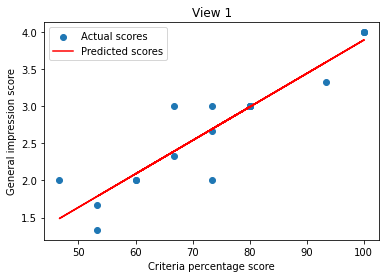

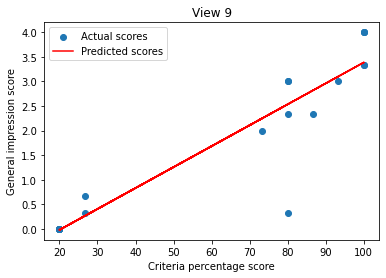

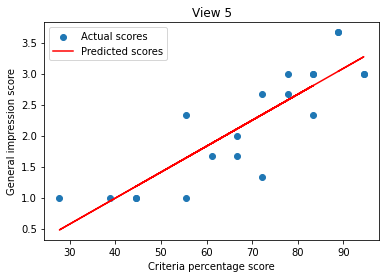

In [6]:
# getting the three best performing cases
bestThree = []
bestThree.append(pltLinearRegression[0])
bestThree.append(pltLinearRegression[8])
bestThree.append(pltLinearRegression[4])

# Plotting the regression output only for the three best performing cases
for view, r2, rmse, crit_perc_scores, gen_impr_scores, y_pred in bestThree:
    plt.figure()
    plt.scatter(crit_perc_scores, gen_impr_scores, label='Actual scores')
    plt.plot(crit_perc_scores, y_pred, color='red', label='Predicted scores')
    plt.xlabel('Criteria percentage score')
    plt.ylabel('General impression score')
    plt.title(f'View {view+1}')
    plt.legend()
    plt.show()


## Question 1 iii)
### Plot the true vs estimated values for three best performing views and comment on the model performance for two different general impression score ranges (0-2, 2-4).

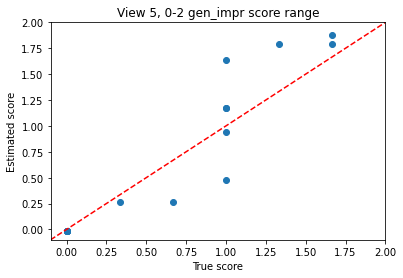

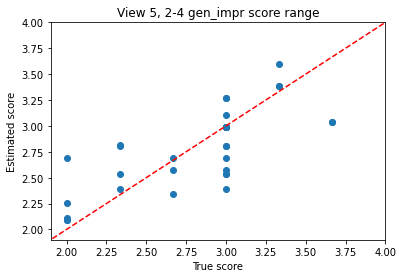

In [7]:
# Define the score ranges
scoreRanges = [(0, 2), (2, 4)]

# Loop over the score ranges
for ranges in scoreRanges:

    trueValues = []
    estimatedValues = []

    # Loop over the views
    for view, r2, rmse, crit_perc_scores, gen_impr_scores, y_pred in bestThree:
        # Extract scores for the view and mask
        genView = _data['gen_impr'].flatten()[view::10]
        critView = _data['crit_perc'].flatten()[view::10]

        # Remove the entries with -1 scores
        genView = genView[genView != -1]
        critView = critView[critView != -1]

        # Perform linear regression
        X = critView.reshape(-1, 1)
        y = genView.reshape(-1, 1)
        LR = LinearRegression().fit(X, y)
        genViewPred = LR.predict(X)

        for generalImpression, generalImpression_pred in zip(genView, genViewPred):
            if ranges[0] <= generalImpression < ranges[1]:
                trueValues.append(generalImpression)
                estimatedValues.append(generalImpression_pred)

        # Plot the true vs estimated values
        #print(trueValues)
        #print(estimatedValues)
    plt.scatter(trueValues, estimatedValues)
    plt.plot([-0.1, 4], [-0.1, 4], 'r--')
    plt.xlim([ranges[0]-0.1,ranges[1]])
    plt.ylim([ranges[0]-0.1,ranges[1]])
    plt.xlabel('True score')
    plt.ylabel('Estimated score')
    plt.title(f'View {view+1}, {ranges[0]}-{ ranges[1]} gen_impr score range')
    plt.show()




# Question 2 i)
### i) Calculate and list the SSI, MI and CS values for each test image against the gold standardones (use the scikit-imag, scikit-learn, scipy libraries). Identify the top three test images (which participant) for each view that have the most similar content to the gold standard ones according to their SSI, MI and CS values.

In [8]:
 # Calculate SSI
def ssi(test_image, gold_image):
    return ssim(test_image, gold_image)

 # Calculate MI
def mi(test_image, gold_image):
    return mutual_info_score(test_image.flatten(), gold_image.flatten())

# Calculate CS
def cs(test_image, gold_image):
     return cosine_similarity(test_image.flatten().reshape(1,-1), gold_image.flatten().reshape(1,-1))[0, 0] # this will ensure that the function returns a scalar value instead of a 2D array.



In [9]:
# Get the test and gold standard images
test_images = _data['test_img']
gold_images = _data['gold_img']

# Initialize dictionaries to store SSI, MI and CS values for each view
test_gold_images = {view: {'SSI': [], 'MI': [], 'CS': []} for view in range(10)}

# Loops through each gold standard image and calculates the SSI, MI and CS values for each test image
for i in range(gold_images.shape[1]):
    for j in range(test_images.shape[0]):
        
        # Skips -1
        if test_images[j][i].size == 0:
            continue

        # Calculate SSI, MI and CS values
        ssi_value = ssi(test_images[j][i], gold_images[0][i])
        mi_value = mi(test_images[j][i], gold_images[0][i])
        cs_value = cs(test_images[j][i], gold_images[0][i])
        
        # Stores SSI, MI and CS
        test_gold_images[i]['SSI'].append(ssi_value)
        test_gold_images[i]['MI'].append(mi_value)
        test_gold_images[i]['CS'].append(cs_value)

In [10]:
# Print the top three test images for each view according to their SSI, MI, and CS values
for view in test_gold_images:
    print(f'View {view+1}:')
    for measure in ['SSI', 'MI', 'CS']:
        sorted_images = sorted(enumerate(test_gold_images[view][measure], start =1), key=lambda x: x[1], reverse=True)[:3]
        print(f'\t{measure}:')
        for rank, (participant, value) in enumerate(sorted_images):
            print(f'\t\t{rank+1}. Participant {participant} (matrics value: {value.item():.8f})')

View 1:
	SSI:
		1. Participant 2 (matrics value: 0.82408660)
		2. Participant 4 (matrics value: 0.81787743)
		3. Participant 12 (matrics value: 0.81708476)
	MI:
		1. Participant 2 (matrics value: 0.00065451)
		2. Participant 4 (matrics value: 0.00062992)
		3. Participant 6 (matrics value: 0.00050715)
	CS:
		1. Participant 2 (matrics value: 0.06201001)
		2. Participant 4 (matrics value: 0.06087600)
		3. Participant 6 (matrics value: 0.05509349)
View 2:
	SSI:
		1. Participant 14 (matrics value: 0.86193244)
		2. Participant 19 (matrics value: 0.85595790)
		3. Participant 8 (matrics value: 0.84617403)
	MI:
		1. Participant 3 (matrics value: 0.00265123)
		2. Participant 14 (matrics value: 0.00178128)
		3. Participant 19 (matrics value: 0.00147262)
	CS:
		1. Participant 14 (matrics value: 0.10647658)
		2. Participant 19 (matrics value: 0.09606520)
		3. Participant 6 (matrics value: 0.09237029)
View 3:
	SSI:
		1. Participant 14 (matrics value: 0.85369146)
		2. Participant 9 (matrics value: 0.

# Question 2 ii)
### For each view develop a hypothesis and perform a statistical test to evaluate the differences between the expert and novice groups in terms of SSI, MI and CS. List and discuss your results in terms of significance. Which similarity metric out of the three better captures the differences between expert and novice surgeons? (10 marks) 


In [261]:
# just like the code above just with 2 dictionaries for the experts(0-6) and novices(7-19) 
expert_similar_images = {view: {'SSI': [], 'MI': [], 'CS': []} for view in range(10)}
novice_similar_images = {view: {'SSI': [], 'MI': [], 'CS': []} for view in range(10)}

for i in range(gold_images.shape[1]):
    for j in range(test_images.shape[0]):
        
        # Skip empty arrays and ignore scores of -1
        if test_images[j][i].size == 0:
            continue

        # Calculate similarity values
        ssi_value = ssi(test_images[j][i], gold_images[0][i])
        mi_value = mi(test_images[j][i], gold_images[0][i])
        cs_value = cs(test_images[j][i], gold_images[0][i])
        
        # Store values in expert or novice dictionaries 
        if j < 7:
            expert_similar_images[i]['SSI'].append(ssi_value)
            expert_similar_images[i]['MI'].append(mi_value)
            expert_similar_images[i]['CS'].append(cs_value)
        else:
            novice_similar_images[i]['SSI'].append(ssi_value)
            novice_similar_images[i]['MI'].append(mi_value)
            novice_similar_images[i]['CS'].append(cs_value)




In [263]:
# Perform independent samples t-tests/u-test (depending if the data is normally distributed)
#for each view between novices and experts

for view in range(10):
    print(f"\nView {view+1}:")
    for measure in ['SSI', 'MI', 'CS']:

        
        expert_values = np.array(expert_similar_images[view][measure])
        novice_values = np.array(novice_similar_images[view][measure])
        expert_mean = np.mean(expert_values)
        novice_mean = np.mean(novice_values)
        print(f"\t{measure}:")
        print(f"\t\tExpert mean: {expert_mean:.4f}")
        print(f"\t\tNovice mean: {novice_mean:.4f}")
        
        use_mannwhitney = False

        # Test for normality using Shapiro-Wilk test
        stat, p = stats.shapiro(expert_values)
        if p > 0.05:
            print("\t\tExpert data is normally distributed")
        else:
            print("\t\tExpert data is not normally distributed")
            use_mannwhitney = True
        
        stat, p = stats.shapiro(novice_values)
        if p > 0.05:
            print("\t\tNovice data is normally distributed")
        else:
            print("\t\tNovice data is not normally distributed")
            use_mannwhitney = True
            
        
        if use_mannwhitney:
            u, p = stats.mannwhitneyu(expert_similar_images[view][measure], novice_similar_images[view][measure])
            print(f"\t\tMann-Whitney U test = {u:.4f}, p = {p:.4f}")
        else:
            t, p = stats.ttest_ind(expert_similar_images[view][measure], novice_similar_images[view][measure])
            print(f"\t\tsamples t-test = {t:.4f}, p = {p:.4f}")
        
        
        
        if p < 0.05:
            print("\t\tThe difference between experts and novices is statistically significant ++")
        else:
            print("\t\tThe difference between experts and novices is not statistically significant --")
        
        
   


View 1:
	SSI:
		Expert mean: 0.8020
		Novice mean: 0.7893
		Expert data is normally distributed
		Novice data is normally distributed
		samples t-test = 1.5815, p = 0.1322
		The difference between experts and novices is not statistically significant --
	MI:
		Expert mean: 0.0004
		Novice mean: 0.0002
		Expert data is normally distributed
		Novice data is normally distributed
		samples t-test = 3.8568, p = 0.0013
		The difference between experts and novices is statistically significant ++
	CS:
		Expert mean: 0.0501
		Novice mean: 0.0355
		Expert data is normally distributed
		Novice data is normally distributed
		samples t-test = 3.9151, p = 0.0011
		The difference between experts and novices is statistically significant ++

View 2:
	SSI:
		Expert mean: 0.8340
		Novice mean: 0.8369
		Expert data is normally distributed
		Novice data is normally distributed
		samples t-test = -0.5012, p = 0.6223
		The difference between experts and novices is not statistically significant --
	MI:
		Expe

# Question 3 i)

### Considering the extracted SSI, MI, and CS values: Calculate the correlation coefficient for SSI and MI, SSI and CS, and MI and CS for each view. Identify for which view, in each pair, the two parameters are in higher agreement.

In [61]:
# Loop through each view and calculate the correlation coefficients
for view in range(10):
    # Get the similarity values for SSI, MI, and CS for the current view
    ssi_values = test_gold_images[view]['SSI']
    mi_values = test_gold_images[view]['MI']
    cs_values = test_gold_images[view]['CS']
    
    # Calculate the correlation coefficients for SSI and MI, SSI and CS, and MI and CS
    ssi_mi_corrcoef = np.corrcoef(ssi_values, mi_values)[0, 1]
    ssi_cs_corrcoef = np.corrcoef(ssi_values, cs_values)[0, 1]
    mi_cs_corrcoef = np.corrcoef(mi_values, cs_values)[0, 1]
    
    # Prints correlation coefficients for the current view
    print(f'View {view+1}: SSI-MI corrcoef = {ssi_mi_corrcoef:.5f}, SSI-CS corrcoef = {ssi_cs_corrcoef:.5f}, MI-CS corrcoef = {mi_cs_corrcoef:.6f}')


View 1: SSI-MI corrcoef = 0.75304, SSI-CS corrcoef = 0.72790, MI-CS corrcoef = 0.993494
View 2: SSI-MI corrcoef = 0.32531, SSI-CS corrcoef = 0.75808, MI-CS corrcoef = 0.642080
View 3: SSI-MI corrcoef = 0.22371, SSI-CS corrcoef = 0.51247, MI-CS corrcoef = 0.569196
View 4: SSI-MI corrcoef = 0.48878, SSI-CS corrcoef = 0.52063, MI-CS corrcoef = 0.996206
View 5: SSI-MI corrcoef = 0.71648, SSI-CS corrcoef = 0.77237, MI-CS corrcoef = 0.980110
View 6: SSI-MI corrcoef = 0.76222, SSI-CS corrcoef = 0.77467, MI-CS corrcoef = 0.985844
View 7: SSI-MI corrcoef = 0.49406, SSI-CS corrcoef = 0.49351, MI-CS corrcoef = 0.991026
View 8: SSI-MI corrcoef = 0.73670, SSI-CS corrcoef = 0.71990, MI-CS corrcoef = 0.988614
View 9: SSI-MI corrcoef = 0.01438, SSI-CS corrcoef = -0.07026, MI-CS corrcoef = 0.986035
View 10: SSI-MI corrcoef = 0.82523, SSI-CS corrcoef = 0.85404, MI-CS corrcoef = 0.986411


# Question 3 ii) 
### Perform polynomial regression using a 7th degree order polynomial for the SSI, MI, and CS against both the criteria percentage and general impression for each view (SSI/MI/CS – independent, manual scores – dependent). In case this leads to overfitting use a regularization method (LASSO, RIDGE or Elastic Net regression) and identify the optimal degree of the polynomial to avoid overfitting. 

## 1) 7th degree order polynomial linear Regression

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Regression coefficients:  [[ 0.00000000e+00 -9.70657398e+11  3.65130880e+12 -7.62950245e+12
   9.56385754e+12 -7.19216463e+12  3.00436320e+12 -5.37783733e+11]]
Regression coefficients:  [[ 0.00000000e+00 -8.62045500e+04  6.21500642e+08 -1.83269647e+12
   2.39263978e+15 -1.14077793e+18 -2.32960003e+15 -2.95735644e+12]]
Regression coefficients:  [[ 0.00000000e+00  9.18388260e+04 -6.21955117e+06  2.22867018e+08
  -4.56230651e+09  5.32808080e+10 -3.27375544e+11  8.09455910e+11]]
Regression coefficients:  [[ 0.00000000e+00  1.25754445e+13 -4.51385190e+13  9.00055698e+13
  -1.07674634e+14  7.72821902e+13 -3.08136924e+13  5.26504569e+12]]
Regression coefficients:  [[ 0.00000000e+00  8.43868297e+03 -1.46201146e+07  1.00129446e+10
  -2.87740999e+12  2.89900739e+14  2.02918138e+12  8.97925757e+09]]
Regression coefficients:  [[ 0.00000000e+00  6.54945712e+04 -3.56278687e+06  1.03308294e+08
  -1.73271105e+09  1.68701767e+10 -8.85383807e+10  1.93676472e+11]]
Regression coefficients:  [[ 0.00000000e

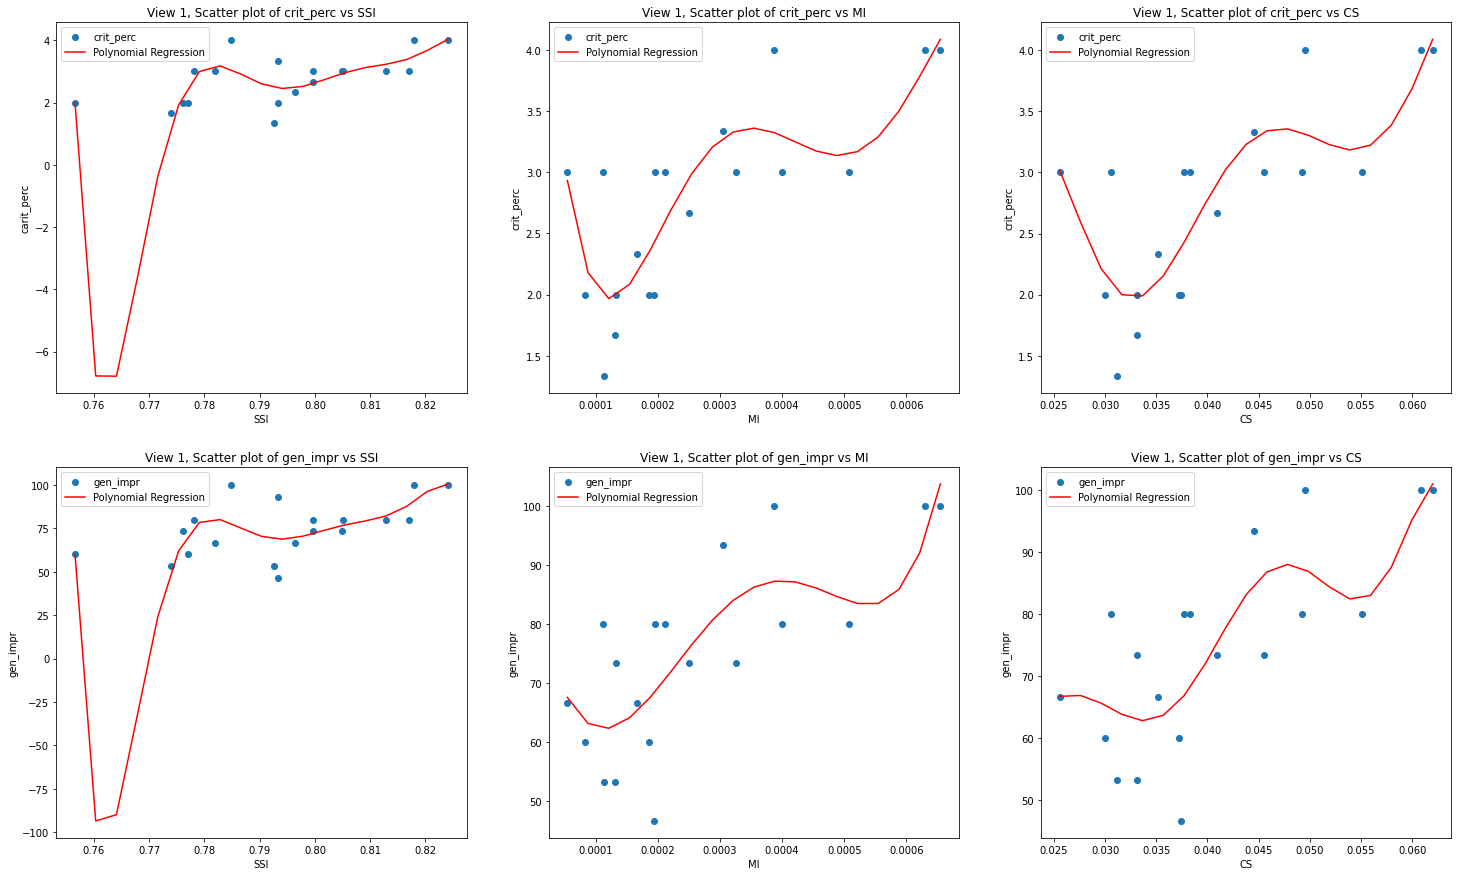

In [62]:
# Dictionaries to store regressions for each view and measure
regressions = {view: {'SSI': [], 'MI': [], 'CS': []} for view in range(10)}

# Loop through each view and measure and perform polynomial regression
for i in range(3):
    for measure in ['SSI', 'MI', 'CS']:
        # Get the independent and dependent variables
        x = np.array(test_gold_images[i][measure])
        y1 = np.array(_data['gen_impr'][:, i])
        y2 = np.array(_data['crit_perc'][:, i])
        
        # Remove the entries with -1 scores
        y1 = y1[y1 != -1]
        y2 = y2[y2 != -1]

        # Fit a 7th degree polynomial regression model
        poly_reg1 = make_pipeline(PolynomialFeatures(7), LinearRegression())
        poly_reg2 = make_pipeline(PolynomialFeatures(7), LinearRegression())

        poly_reg1.fit(x[:,np.newaxis], y1.reshape(-1, 1))
        poly_reg2.fit(x[:,np.newaxis], y2.reshape(-1, 1))

        # Predict the dependent variable using the trained regression model
        x_fit = np.linspace(x.min(), x.max(), len(x))
        y1_pred = poly_reg1.predict(x_fit[:,np.newaxis])
        y2_pred = poly_reg2.predict(x_fit[:,np.newaxis])
        
        
        #To consider regression coefficients smaller than 0.01 as not contributing to the regression,set  to 0. 
        reCoef1 =poly_reg1['linearregression'].coef_
        
        reCoef1 = np.where(np.logical_and(reCoef1 > -0.01, reCoef1 < 0.01), 0, reCoef1)
        print("Regression coefficients: ",reCoef1 )
        
        #Store regressions in dictionary
        regressions[i][measure] = [x, y1, y2, x_fit, y1_pred, y2_pred]

#increase number of views to see more linear regressions (1 - 10) views
view = 1
makePlots(regressions, view-1)       



#### As you can see in the above graph there is overfitting therefore regularization is used and Lasso is a good regularise to use

## 2) 7th degree order polynomial using LASSO Regularisation

In [57]:
# Initialize dictionaries to store regressions for each view and measure
regressions_lasso = {view: {'SSI': [], 'MI': [], 'CS': []} for view in range(10)}

# Define the degree of the polynomial and alpha
degree = 7
alphas = [ 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10]

# Loop through each view and measure and perform polynomial regression
for i in range(10):
    print(f"\nView {i+1}:")
    for measure in ['SSI', 'MI', 'CS']:
        # Get the independent and dependent variables
        x = np.array(test_gold_images[i][measure])
        y1 = np.array(_data['gen_impr'][:, i])
        y2 = np.array(_data['crit_perc'][:, i])
        x_fit = np.linspace(x.min(), x.max(), len(x))
        print(f"\n\t{measure}:")
        # Remove the entries with -1 scores
        y1 = y1[y1 != -1]
        y2 = y2[y2 != -1]
        
        ########################################################gen_impr####################################
        # Fit the polynomial regression model with Lasso regularization using the optimal degree
        poly_reg1 = make_pipeline(PolynomialFeatures(7), LassoCV(alphas=alphas, cv=5, max_iter=1e6, tol =1 ))
        poly_reg1.fit(x[:,np.newaxis], y1.ravel())
        
    
        # Predict the dependent variable using the trained regression model
        y1_pred = poly_reg1.predict(x[:,np.newaxis])
        
        # Calculate the RMSE and R2 scores
        rmse_1 = mean_squared_error(y1, y1_pred, squared=False)
        r2_1 = r2_score(y1, y1_pred)
        
        print(f"View {i+1}: RMSE = {rmse_1:.5f}, R2 = {r2_1:.5f}")
        # Predict the dependent variable using the trained regression model
        
        #Print regression coefficients
        reCoef1 =poly_reg1['lassocv'].coef_
        
        #To consider regression coefficients smaller than 0.01 as not contributing to the regression,set  to 0. 
        reCoef1 = np.where(np.logical_and(reCoef1 > -0.01, reCoef1 < 0.01), 0, reCoef1)
        print("Regression coefficients: ",reCoef1 )
        
        y1_pred = poly_reg1.predict(x_fit[:,np.newaxis])
        
        #############################################################crit_perc############################################ 
        #########################code is the same above but now for the critical percentage###############################
        
        
        poly_reg2 = make_pipeline(PolynomialFeatures(7), LassoCV(alphas=alphas, cv =5, max_iter=1e6, tol=0.001 ))    
        poly_reg2.fit(x[:,np.newaxis], y2.ravel())
             
        
        y2_pred = poly_reg2.predict(x[:,np.newaxis])
        
        rmse_2 = mean_squared_error(y2, y2_pred, squared=False)
        r2_2 = r2_score(y2, y2_pred)

        print(f"View {i+1}: RMSE = {rmse_2:.5f}, R2 = {r2_2:.5f}")
        
        reCoef2 =poly_reg2['lassocv'].coef_
        
        reCoef2 = np.where(np.logical_and(reCoef2 > -0.01, reCoef2 < 0.01), 0, reCoef2)

        print("Regression coefficients: ",reCoef2 )  
        
        y2_pred = poly_reg2.predict(x_fit[:,np.newaxis])
        
        #Store regressions in dictionary
        regressions_lasso[i][measure] = [x, y1, y2, x_fit, y1_pred, y2_pred, rmse_1, r2_1, rmse_2, r2_2, reCoef1, reCoef2]

    



View 1:

	SSI:
View 1: RMSE = 0.62427, R2 = 0.33147
Regression coefficients:  [ 0.         25.16162689  0.10557517  0.08969507  0.08563061  0.08709579
  0.09216678  0.10020093]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 941.1582383415761, tolerance: 2.388148148148146
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1251.4597276004854, tolerance: 4.077037037037038
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1132.1678944185317, tolerance: 3.632592592592592
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increa

View 1: RMSE = 13.04359, R2 = 0.30835
Regression coefficients:  [   0.         -708.90099229 -173.11285663    0.            0.
    0.          322.89780689  494.25510118]

	MI:
View 1: RMSE = 0.51454, R2 = 0.54584
Regression coefficients:  [   0.         3257.50799846    0.            0.            0.
    0.            0.            0.        ]
View 1: RMSE = 10.64108, R2 = 0.53967
Regression coefficients:  [    0.         63290.55586198     0.             0.
     0.             0.             0.             0.        ]

	CS:
View 1: RMSE = 0.52546, R2 = 0.52635
Regression coefficients:  [  0.          52.11324288  26.99866358 230.87304039 906.64024121
   0.           0.           0.        ]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 591.822095936527, tolerance: 3.3066666666666658
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.9989514658666, tolerance: 4.611111111111111
  positive,


View 1: RMSE = 10.70963, R2 = 0.53372
Regression coefficients:  [   0.         1114.15080073    0.            0.            0.
    0.            0.            0.        ]

View 2:

	SSI:
View 2: RMSE = 0.75695, R2 = 0.07222
Regression coefficients:  [ 0.         19.58186678 -0.31748028 -0.2523123  -0.22526206 -0.21432179
 -0.21221412 -0.21593404]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 774.3470363472081, tolerance: 2.7305555555555547
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 922.4100774508123, tolerance: 3.4222333437500003
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1180.2810855856364, tolerance: 3.900016677083333
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to incre

View 2: RMSE = 11.79646, R2 = 0.35938
Regression coefficients:  [    0.          5982.91086147  2019.34238684     0.
     0.             0.         -1818.0083807  -1845.08934903]

	MI:
View 2: RMSE = 0.78586, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]
View 2: RMSE = 14.73848, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]

	CS:
View 2: RMSE = 0.78586, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 993.5685391467496, tolerance: 3.4222333437500003
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1252.1760179679366, tolerance: 3.900016677083333
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1372.8764620275551, tolerance: 4.197230565972221
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to incre

View 2: RMSE = 14.73848, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]

View 3:

	SSI:
View 3: RMSE = 0.75331, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 972.7447971828531, tolerance: 2.2222222222222223
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1608.369447538475, tolerance: 4.400100010416667
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1819.6485712990893, tolerance: 5.055661121527778
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increa

View 3: RMSE = 14.79026, R2 = 0.21219
Regression coefficients:  [    0.          8064.38651404  8123.19046414     0.
     0.             0.         -2327.33409442 -6694.64462012]

	MI:
View 3: RMSE = 0.73238, R2 = 0.05480
Regression coefficients:  [  0.         117.29760498   0.           0.           0.
   0.           0.           0.        ]
View 3: RMSE = 16.38668, R2 = 0.03295
Regression coefficients:  [   0.         2639.85189959    0.            0.            0.
    0.            0.            0.        ]

	CS:
View 3: RMSE = 0.70998, R2 = 0.11173
Regression coefficients:  [ 0.00000000e+00  2.27464230e+01 -5.78096444e+01 -5.54768217e+02
 -5.21135004e+03 -3.70721627e+04  0.00000000e+00  0.00000000e+00]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 643.0750846024606, tolerance: 2.2222222222222223
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1097.1486932386774, tolerance: 4.400100010416667
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 839.9264624535246, tolerance: 5.055661121527778
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increa

View 3: RMSE = 16.66350, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]

View 4:

	SSI:
View 4: RMSE = 0.82251, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1844.094241233595, tolerance: 5.027777777777778
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2438.040729742025, tolerance: 6.314814814814814
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2317.452767557679, tolerance: 5.3888888888888875
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increas

View 4: RMSE = 17.38342, R2 = 0.15996
Regression coefficients:  [   0.            0.            0.            0.            0.
    0.            0.         -251.60479468]

	MI:
View 4: RMSE = 0.69845, R2 = 0.27891
Regression coefficients:  [    0.          1398.5763996  47051.93017745     0.
     0.             0.             0.             0.        ]
View 4: RMSE = 18.49109, R2 = 0.04950
Regression coefficients:  [    0.         12950.71325428     0.             0.
     0.             0.             0.             0.        ]

	CS:
View 4: RMSE = 0.71148, R2 = 0.25176
Regression coefficients:  [  0.          20.52471743  25.96115236 148.82247304 708.91573653
 191.30090489   0.           0.        ]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 900.2839698155086, tolerance: 5.027777777777778
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 981.7517160468392, tolerance: 6.314814814814814
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1043.0997276300207, tolerance: 5.3888888888888875
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increa

View 4: RMSE = 18.72795, R2 = 0.02499
Regression coefficients:  [  0.         147.31997329   0.           0.           0.
   0.           0.           0.        ]

View 5:

	SSI:
View 5: RMSE = 0.67837, R2 = 0.44332
Regression coefficients:  [ 0.        38.3113755  0.         0.         0.         0.
  0.         0.       ]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1414.8297756391707, tolerance: 4.4985216095679
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1395.666535711263, tolerance: 3.3873456790123457
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2296.765210189771, tolerance: 6.649347226851849
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase

View 5: RMSE = 16.41144, R2 = 0.24381
Regression coefficients:  [  0.           0.           0.           0.           0.
 168.89287805  64.57105154   0.        ]

	MI:
View 5: RMSE = 0.81846, R2 = 0.18967
Regression coefficients:  [  0.         417.53505793   0.           0.           0.
   0.           0.           0.        ]
View 5: RMSE = 17.83059, R2 = 0.10738
Regression coefficients:  [   0.         7451.65913562    0.            0.            0.
    0.            0.            0.        ]

	CS:
View 5: RMSE = 0.79617, R2 = 0.23320
Regression coefficients:  [ 0.         15.53786524  0.          0.          0.          0.
  0.          0.        ]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1171.9615115179097, tolerance: 3.3873456790123457
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2454.242854298072, tolerance: 6.649347226851849
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2279.8166697655342, tolerance: 6.8653996959876515
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to incr

View 5: RMSE = 17.61925, R2 = 0.12841
Regression coefficients:  [  0.         246.81271955   0.           0.           0.
   0.           0.           0.        ]

View 6:

	SSI:
View 6: RMSE = 1.05620, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4212.685533969548, tolerance: 9.411111111111111
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4510.604090981732, tolerance: 12.133333333333333
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5038.937753383609, tolerance: 13.233333333333333
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increa

View 6: RMSE = 25.39250, R2 = 0.20496
Regression coefficients:  [     0.         -10078.6682501   -1377.58180172      0.
      0.           2028.09628932   2193.56635213   2418.05300308]

	MI:
View 6: RMSE = 0.91567, R2 = 0.24840
Regression coefficients:  [   0.         1252.04274406    0.            0.            0.
    0.            0.            0.        ]
View 6: RMSE = 23.82050, R2 = 0.30035
Regression coefficients:  [    0.         36561.38357172     0.             0.
     0.             0.             0.             0.        ]

	CS:
View 6: RMSE = 0.91189, R2 = 0.25459
Regression coefficients:  [0.00000000e+00 2.36571199e+01 8.35383613e+00 1.29535622e+02
 1.36157325e+03 9.01978147e+03 0.00000000e+00 0.00000000e+00]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3020.6600204750907, tolerance: 9.411111111111111
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4012.521908501742, tolerance: 12.133333333333333
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2837.149750126931, tolerance: 14.819444444444443
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to incre

View 6: RMSE = 23.22717, R2 = 0.33477
Regression coefficients:  [  0.         796.42009703   0.           0.           0.
   0.           0.           0.        ]

View 7:

	SSI:
View 7: RMSE = 1.17746, R2 = 0.09320
Regression coefficients:  [  0.         -20.35793591  -3.99466148  -1.02572212  -0.42738057
  -0.21182084  -0.10454776  -0.03635845]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5749.60482841107, tolerance: 14.982638888888891
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4061.4201871250884, tolerance: 9.370659722222223
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6585.429105070463, tolerance: 15.342881944444446
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increa

View 7: RMSE = 29.39199, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]

	MI:
View 7: RMSE = 1.11683, R2 = 0.18418
Regression coefficients:  [  0.         891.75661368   0.           0.           0.
   0.           0.           0.        ]
View 7: RMSE = 25.63201, R2 = 0.23949
Regression coefficients:  [        0.             72999.51690623 -24871342.61110083
         0.                 0.                 0.
         0.                 0.        ]

	CS:
View 7: RMSE = 1.07092, R2 = 0.24986
Regression coefficients:  [ 0.         30.07039357  0.          0.          0.          0.
  0.          0.        ]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3535.849342347132, tolerance: 14.982638888888891
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3259.130883644188, tolerance: 9.370659722222223
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5739.081129404923, tolerance: 15.342881944444446
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increa

View 7: RMSE = 25.63804, R2 = 0.23913
Regression coefficients:  [  0.         734.22589709   0.           0.           0.
   0.           0.           0.        ]

View 8:

	SSI:
View 8: RMSE = 0.89491, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 711.7705432021651, tolerance: 1.511111111111111
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1351.6409698356397, tolerance: 3.3659259259259247
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845.3006388643923, tolerance: 4.165925925925925
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to incre

View 8: RMSE = 14.14903, R2 = 0.13044
Regression coefficients:  [     0.          96483.09205156 -41154.67672117 -24218.09303297
 -13009.36290558  -3132.88772655   7167.63968026  19036.23719333]

	MI:
View 8: RMSE = 0.89491, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]
View 8: RMSE = 12.86950, R2 = 0.28060
Regression coefficients:  [    0.        28276.3291445     0.            0.            0.
     0.            0.            0.       ]

	CS:
View 8: RMSE = 0.89491, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 946.857073608427, tolerance: 3.3659259259259247
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1348.0819126207289, tolerance: 4.165925925925925
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 943.9120234569494, tolerance: 3.7748148148148144
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increa

View 8: RMSE = 12.68675, R2 = 0.30088
Regression coefficients:  [  0.         542.60048995   0.           0.           0.
   0.           0.           0.        ]

View 9:

	SSI:
View 9: RMSE = 1.56800, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7646.456763408247, tolerance: 17.677777777777777
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6900.684680208911, tolerance: 17.41111111111111
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7986.9542307471875, tolerance: 18.66388888888889
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increa

View 9: RMSE = 34.14186, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]

	MI:
View 9: RMSE = 1.56800, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]
View 9: RMSE = 34.14186, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]

	CS:
View 9: RMSE = 1.56800, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7821.394598315383, tolerance: 17.677777777777777
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6902.549685315677, tolerance: 17.41111111111111
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8486.277916100795, tolerance: 18.66388888888889
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increas

View 9: RMSE = 34.14186, R2 = 0.00000
Regression coefficients:  [0. 0. 0. 0. 0. 0. 0. 0.]

View 10:

	SSI:
View 10: RMSE = 1.02718, R2 = 0.10976
Regression coefficients:  [ 0.         30.35353974  0.54026362  0.22138552  0.15336426  0.13060099
  0.12279973  0.12180172]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3151.0436907380995, tolerance: 8.606701940035274
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3199.778512688413, tolerance: 8.500881834215168
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2925.85495998131, tolerance: 9.473104056437391
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase

View 10: RMSE = 21.55676, R2 = 0.22223
Regression coefficients:  [  0.           0.           0.           0.         451.45512294
   0.           0.           0.        ]

	MI:
View 10: RMSE = 0.98905, R2 = 0.17462
Regression coefficients:  [    0.           496.80389291 17558.78443454     0.
     0.             0.             0.             0.        ]
View 10: RMSE = 22.15563, R2 = 0.17842
Regression coefficients:  [    0.         10805.91165607     0.             0.
     0.             0.             0.             0.        ]

	CS:
View 10: RMSE = 0.99870, R2 = 0.15844
Regression coefficients:  [ 0.         13.45334926  8.08239134  0.          0.          0.
  0.          0.        ]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2097.0207056605377, tolerance: 8.606701940035274
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2354.9065357886752, tolerance: 8.500881834215168
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1715.0333656922367, tolerance: 9.473104056437391
  positive,
C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to incre

View 10: RMSE = 21.85130, R2 = 0.20083
Regression coefficients:  [  0.         353.33304949   0.           0.           0.
   0.           0.           0.        ]


C:\Users\Admin\anaconda3\envs\sds\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1616.480479061658, tolerance: 8.757201646090536
  positive,


## Selecting the best three views based on the combination of R2 score and RMSE values for each view

[3 1 0]
Top three views based on the combination of R2 score and RMSE values for each view:
View 1
View 2
View 4


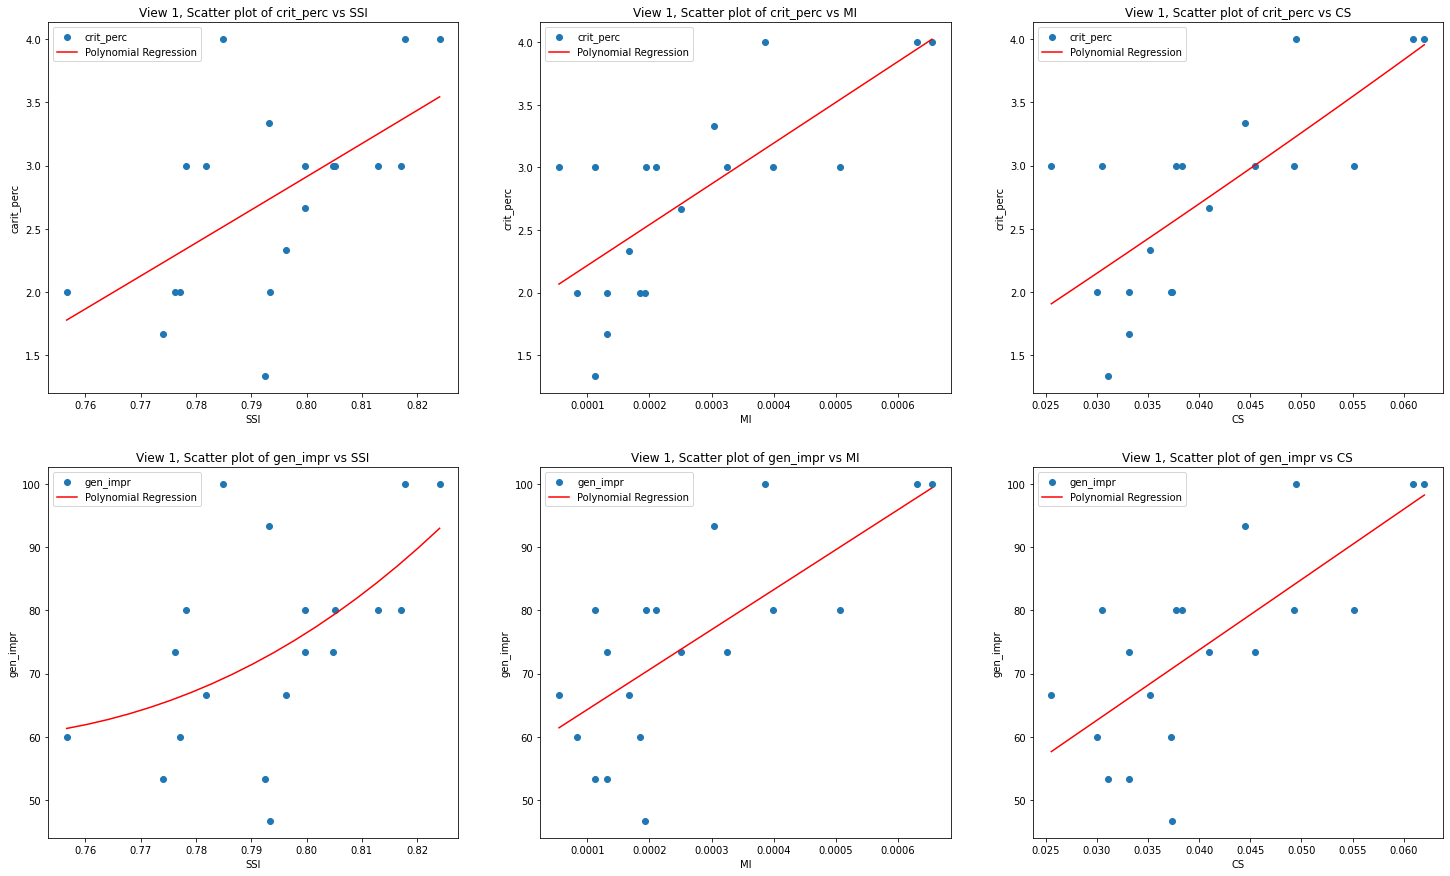

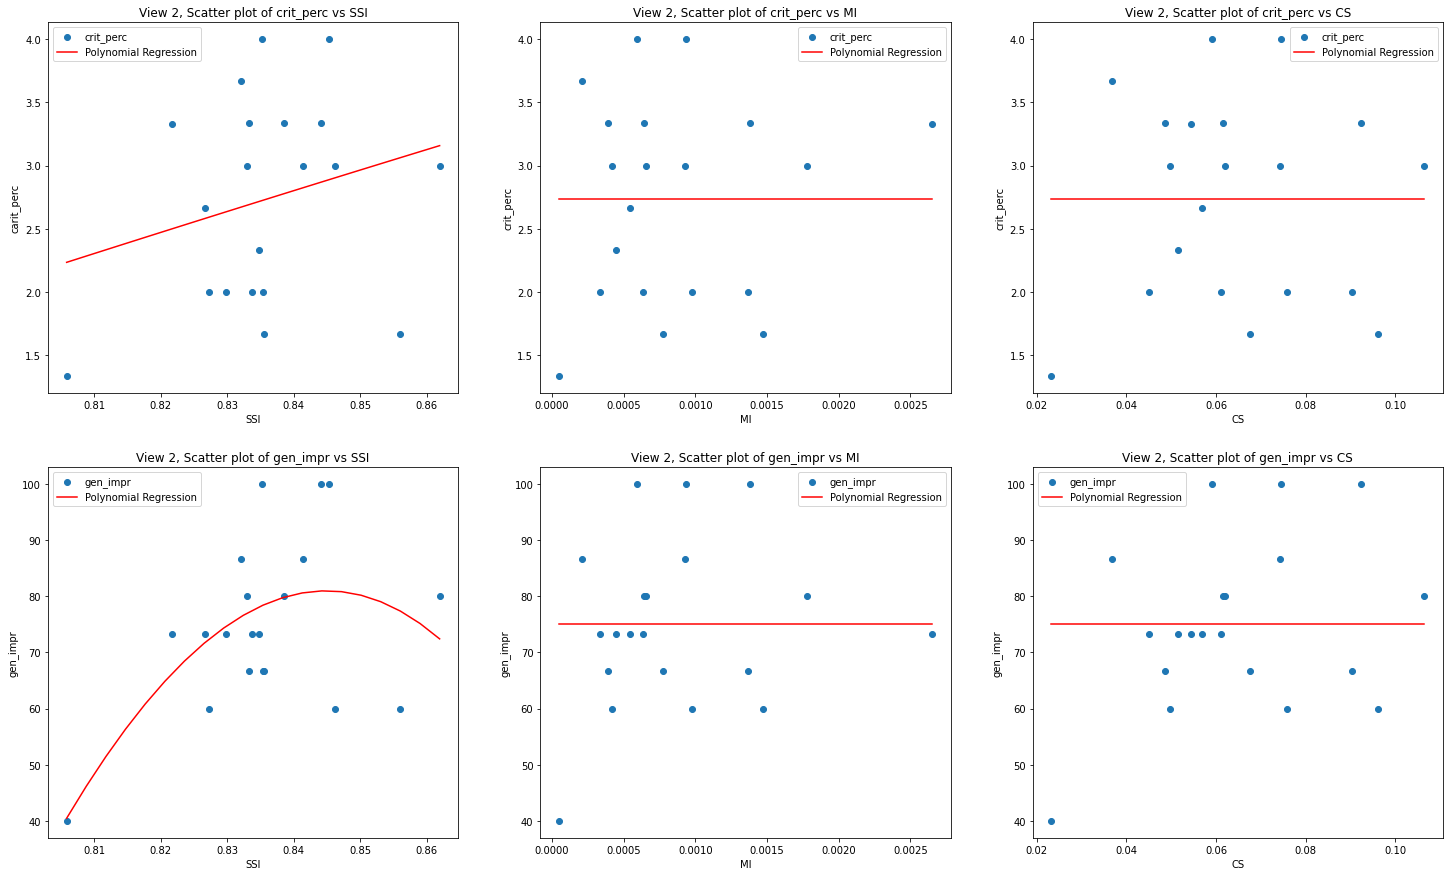

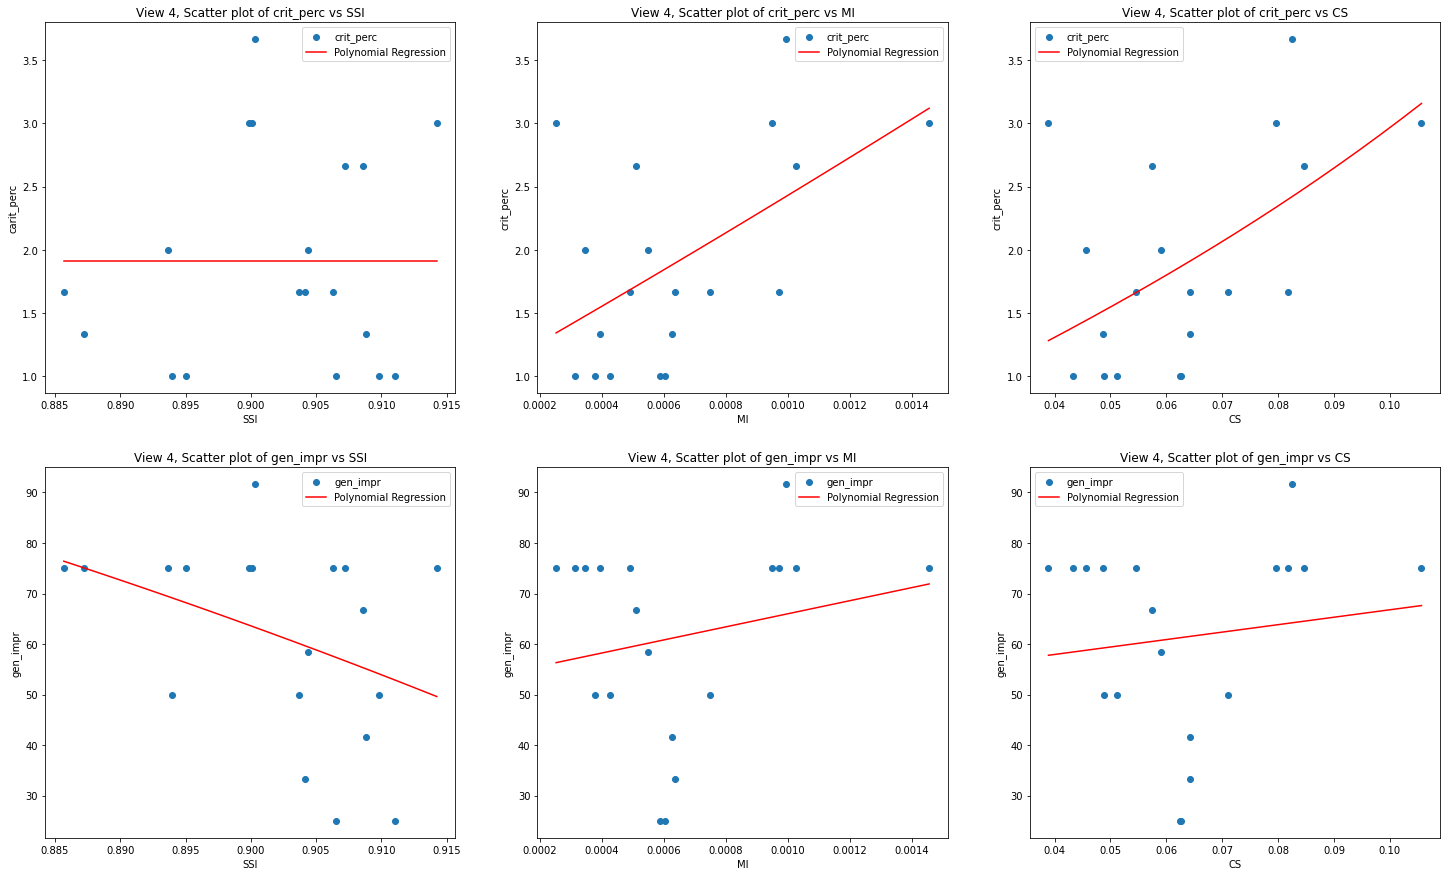

In [60]:
# the idea to find the top 3 views is to scale
#in order to find the top 3 views we need to assign a score to each plot in each view.
#since each plot is measured by each rmse value and r2 value, our scoring function should take both values as inputs
# however rmse r2 are not in the same range therefore we scale both values between 0 and 1 
# further more rmse lower is better where as the r2 is the inverse therefore we -1 our scaled rmse 
# so that larger rmse is better
# lastly we add them together as a ratio so the resulting score is between 0 and 1
# I weight the ratio more for the rmse than the r2 score as it as rmse is more important 
# I find the best plot for each view and then the top 3 plots of the views. 


rmse = np.zeros((6, 10))
r2 = np.zeros((6, 10))
# for each view
for j in range(10):
    # for each plot in view get the 6 RMSE values and 6 R2 values 
    counter = 0
    for measure in ['SSI', 'MI', 'CS']:
        rmse[counter, j] = regressions_lasso[j][measure][6]
        rmse[counter+1, j] = regressions_lasso[j][measure][8]
        r2[counter, j] = regressions_lasso[j][measure][7]
        r2[counter+1, j] = regressions_lasso[j][measure][9]
        counter += 2

# scale rmse to 0 and 1
rmse = (rmse - np.min(rmse)) / np.max(rmse - np.min(rmse))

# flip rmse, so larger is better
rmse = 1 - rmse

# scale r2 to 0 and 1
r2 = (r2- np.min(r2)) / np.max(r2- np.min(r2))

# weight them as a ratio,  R2 score is more important compared to rmse in determinging performace of t
weight = 0.4
score = (1 - weight)* rmse + weight * r2

# find top 3 view. i.e. columns in this case
# first find the best for each view
top_each_view = np.argmax(score, axis=1)

# then find the best 3 views
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
indices = np.argpartition(top_each_view, -3)[-3:]

print(indices)
print("Top three views based on the combination of R2 score and RMSE values for each view:")
for view in indices[::-1]:
    print(f"View {view+1}")
    makePlots(regressions_lasso, view)

# Question 3 iii)
### Perform linear regression using Gaussian basis for the SSI against the criteria percentage for each view (SSI – independent, criteria percentage – dependent). Decide the order of the gaussian basis, so that the regression model will not underfit/overfit (you can also use a regularizer). Calculate and list the RMSE and R2  scores of your regularized regression. Identify the three views for which the regularized regression performs better. Plot the regression output only for the three best performing cases. Please refer to the code provided in tutorials (available in Moodle) to develop your regression model.


the Gaussian function
$$ f(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2} } e^{ -\frac{(x-\mu)^2}{2\sigma^2} } \sim e^{ -0.5 (\frac{x-\mu}{\sigma})^2} $$ 

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    # Build the Gaussian Basis according to the simplified equation above
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range: These will represent 
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        
        return self
        
        # define the Gaussian tranformer: This will perform a similar operation as the Polynomial transformer we saw in the previous example
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

In [64]:
crit_perc = _data['crit_perc']

# Initialize dictionaries to store regressions for each view and measure
regressions_gaussian = {view: {'SSI': []} for view in range(10)}

for i in range(10):
    x = np.array(test_gold_images[i]['SSI'])
    y = np.array(crit_perc[:, i])
    y = y[y != -1]

    # Define the pipeline for  Gaussian basis polynomial regression with Lasso regularization
    degrees = [ 2, 3, 4, 5, 6, 7, 8, 9, 10]
    best_degree = None
    best_rmse = float('inf')
    alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
    
    # Use cross-validation to select the optimal degree for the polynomial regression
    #selecting the optimal degree for Gaussian basis based on the one with the lowest rmse
    for degree in degrees:
        model = make_pipeline(GaussianFeatures(degree) ,RidgeCV(alphas=alphas, cv=5))
        model.fit(x[:, np.newaxis], y)
        y_pred = model.predict(x[:, np.newaxis])
        rmse = mean_squared_error(y, y_pred, squared=False)
        if rmse < best_rmse:
            best_rmse = rmse
            best_degree = degree
            
    # Fit the optimal model with the best degree and calculate the RMSE and R2 scores
    model = make_pipeline(GaussianFeatures(best_degree), RidgeCV(alphas=alphas, cv=5))
    model.fit(x[:, np.newaxis], y)
    #print("Regression coefficients: ", model['ridgecv'].coef_)
    reCoef = model['ridgecv'].coef_
    y_pred = model.predict(x[:, np.newaxis])
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    print(f"View {i+1}: RMSE = {rmse:.5f}, R2 = {r2:.5f}")

   
    
    # Plot the regression line
    x_fit = np.linspace(x.min(), x.max(), len(x))
    y_fit = model.predict(x_fit[:, np.newaxis])
     # Store the results in the dictionary
    regressions_gaussian[i]['SSI'] = [reCoef, x, y, y_pred, rmse, r2, best_degree,x_fit, y_fit ]
    
    


View 1: RMSE = 13.06215, R2 = 0.30638
View 2: RMSE = 11.92096, R2 = 0.34579
View 3: RMSE = 14.73169, R2 = 0.21842
View 4: RMSE = 17.19027, R2 = 0.17853
View 5: RMSE = 15.50205, R2 = 0.32529
View 6: RMSE = 20.68641, R2 = 0.47235
View 7: RMSE = 27.40330, R2 = 0.13074
View 8: RMSE = 13.60971, R2 = 0.19546
View 9: RMSE = 27.96770, R2 = 0.32897
View 10: RMSE = 19.12305, R2 = 0.38793


## Selecting the best three views based on the combination of R2 score and RMSE values for each view

[4 1 0]
Top three views based on the combination of R2 score and RMSE values for each view:
View 1
RMSE = 13.06215, R2 = 0.30638
Regression coefficients:  [0.7848838  0.8240866  0.80487619 0.81787743 0.7761787  0.8128832
 0.79328357 0.75659335 0.77814847 0.79253059 0.77402359 0.81708476
 0.77709892 0.79634385 0.7818386  0.79336708 0.79970456 0.79973437
 0.80517044]


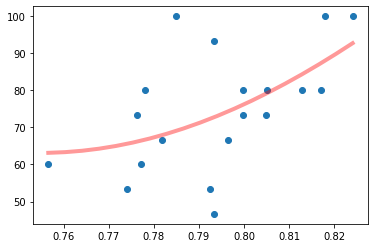

View 2
RMSE = 11.92096, R2 = 0.34579
Regression coefficients:  [0.83519514 0.84528543 0.82159283 0.8320215  0.82661868 0.84408336
 0.83318842 0.84617403 0.83469592 0.84136552 0.83542161 0.82727208
 0.83555293 0.86193244 0.83855419 0.83302598 0.80581473 0.8298038
 0.8559579  0.83371136]


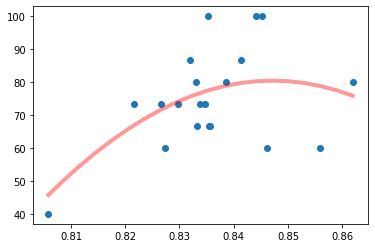

View 5
RMSE = 15.50205, R2 = 0.32529
Regression coefficients:  [0.8341339  0.87618328 0.84972245 0.83591103 0.84614843 0.82625885
 0.83282779 0.80429143 0.84458062 0.84205137 0.84826439 0.81283458
 0.83749695 0.80594389 0.84057209 0.84980764 0.83690808 0.83548572
 0.83381854 0.8450134 ]


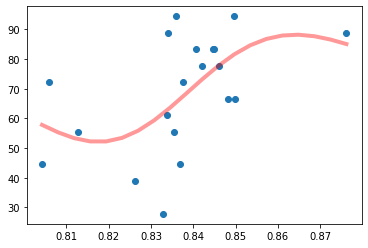

In [65]:

rmse = np.zeros(10)
r2 = np.zeros(10)
for i in range(10):
    rmse[i] = regressions_gaussian[i]['SSI'][4]
    r2[i] = regressions_gaussian[i]['SSI'][5]

# scale rmse to 0 and 1
rmse = (rmse - np.min(rmse)) / np.max(rmse - np.min(rmse))
# flip rmse, so larger is better
rmse = 1 - rmse
# scale r2 to 0 and 1
r2 = (r2- np.min(r2)) / np.max(r2- np.min(r2))

# weigh them, get score
weight = 0.4
score = (1 - weight)* rmse + weight * r2

# find top 3 view. i.e. columns in this case
# first find the best for each view
top_each_view = np.argmax(score, axis=0)
# then find the best 3 views
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
indices = np.argpartition(score, -3)[-3:]
print(indices)

print("Top three views based on the combination of R2 score and RMSE values for each view:")
for i in indices[::-1]:
    print(f"View {i+1}")
    print(f"RMSE = {regressions_gaussian[i]['SSI'][4]:.5f}, R2 = {regressions_gaussian[i]['SSI'][5]:.5f}")
    print("Regression coefficients: ", regressions_lasso[i]['SSI'][0])
    plt.scatter(regressions_gaussian[i]['SSI'][1], regressions_gaussian[i]['SSI'][2])
    plt.plot(regressions_gaussian[i]['SSI'][7], regressions_gaussian[i]['SSI'][8], linewidth=4, color='r', alpha=0.4)
    plt.show()
    
    #6,10,2
    

## The function below helps with plotting the regression plots 

In [16]:
def makePlots(regressions, i):
        # Plot the scatter plot of the predicted values against the original values
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25,15))

    # Plot 1
    axs[0,0].scatter(regressions[i]['SSI'][0], regressions[i]['SSI'][1], label='crit_perc')
    axs[0,0].plot(regressions[i]['SSI'][3], regressions[i]['SSI'][4], color='red', label='Polynomial Regression')
    axs[0,0].set_xlabel('SSI')
    axs[0,0].set_ylabel('carit_perc')
    axs[0,0].set_title(f'View {i+1}, Scatter plot of crit_perc vs SSI')
    axs[0,0].legend()

    # Plot 2
    axs[0,1].scatter(regressions[i]['MI'][0], regressions[i]['MI'][1], label='crit_perc')
    axs[0,1].plot(regressions[i]['MI'][3], regressions[i]['MI'][4], color='red', label='Polynomial Regression')
    axs[0,1].set_xlabel('MI')
    axs[0,1].set_ylabel('crit_perc')
    axs[0,1].set_title(f'View {i+1}, Scatter plot of crit_perc vs MI')
    axs[0,1].legend()

    # Plot 3
    axs[0,2].scatter(regressions[i]['CS'][0], regressions[i]['CS'][1], label='crit_perc')
    axs[0,2].plot(regressions[i]['CS'][3], regressions[i]['CS'][4], color='red', label='Polynomial Regression')
    axs[0,2].set_xlabel('CS')
    axs[0,2].set_ylabel('crit_perc')
    axs[0,2].set_title(f'View {i+1}, Scatter plot of crit_perc vs CS')
    axs[0,2].legend()

    # Plot 4
    axs[1,0].scatter(regressions[i]['SSI'][0], regressions[i]['SSI'][2], label='gen_impr')
    axs[1,0].plot(regressions[i]['SSI'][3], regressions[i]['SSI'][5], color='red', label='Polynomial Regression')
    axs[1,0].set_xlabel('SSI')
    axs[1,0].set_ylabel('gen_impr')
    axs[1,0].set_title(f'View {i+1}, Scatter plot of gen_impr vs SSI')
    axs[1,0].legend()

    # Plot 5
    axs[1,1].scatter(regressions[i]['MI'][0], regressions[i]['MI'][2], label='gen_impr')
    axs[1,1].plot(regressions[i]['MI'][3], regressions[i]['MI'][5], color='red', label='Polynomial Regression')
    axs[1,1].set_xlabel('MI')
    axs[1,1].set_ylabel('gen_impr')
    axs[1,1].set_title(f'View {i+1}, Scatter plot of gen_impr vs MI')
    axs[1,1].legend()
    
    # Plot 6
    axs[1,2].scatter(regressions[i]['CS'][0], regressions[i]['CS'][2], label='gen_impr')
    axs[1,2].plot(regressions[i]['CS'][3], regressions[i]['CS'][5], color='red', label='Polynomial Regression')
    axs[1,2].set_xlabel('CS')
    axs[1,2].set_ylabel('gen_impr')
    axs[1,2].set_title(f'View {i+1}, Scatter plot of gen_impr vs CS')
    axs[1,2].legend()
